In [13]:
import warnings; warnings.filterwarnings(action='ignore')
from matplotlib import pyplot as plt
%matplotlib inline
import geopandas as gpd
import dask_geopandas as dgpd

In [30]:
shapes = gpd.read_file("World\World.shp")
shapes.head()

2023-09-13 09:43:45,032 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x000001E782365D90>>
Traceback (most recent call last):
  File "C:\Users\thoma\AppData\Local\Programs\Python\Python39\Lib\site-packages\tornado\ioloop.py", line 919, in _run
    val = self.callback()
  File "C:\Users\thoma\AppData\Local\Programs\Python\Python39\Lib\site-packages\bokeh\server\tornado.py", line 779, in _keep_alive
    c.send_ping()
  File "C:\Users\thoma\AppData\Local\Programs\Python\Python39\Lib\site-packages\bokeh\server\connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "C:\Users\thoma\AppData\Local\Programs\Python\Python39\Lib\site-packages\tornado\websocket.py", line 439, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2023-09-13 09:43:47,112 - tornado.application - ERROR - Exception in callback <bound method BokehTorn

,GRID_ID,Continent,geometry
0,LI-202,8,"POLYGON ((-6574005.766 -1168083.871, -6588005...."
1,GJ-99,8,"POLYGON ((-11964003.452 3851397.214, -11992003..."
2,KL-174,8,"POLYGON ((-7512005.364 214092.080, -7540005.35..."
3,JT-203,8,"POLYGON ((-8268005.039 -1192332.572, -8296005...."
4,GS-114,8,"POLYGON ((-11586003.614 3099687.486, -11614003..."


<AxesSubplot:>

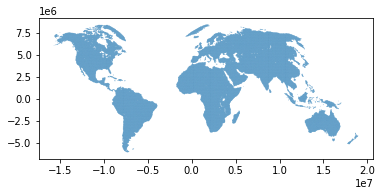

In [8]:
shapes.loc[:, 'geometry'].plot()

In [3]:
neighbors = shapes[~shapes.geometry.disjoint(shapes.iloc[0]['geometry'])]
neighbors

,GRID_ID,Continent,geometry
0,LI-202,8,"POLYGON ((-6574005.766 -1168083.871, -6588005...."
212,LH-203,8,"POLYGON ((-6574005.766 -1168083.871, -6588005...."
2086,LJ-202,8,"POLYGON ((-6504005.797 -1143835.170, -6532005...."
3155,LJ-203,8,"POLYGON ((-6504005.797 -1192332.572, -6532005...."
6740,LI-201,8,"POLYGON ((-6574005.766 -1071089.067, -6546005...."
7296,LH-202,8,"POLYGON ((-6588005.761 -1143835.170, -6616005...."
7649,LI-203,8,"POLYGON ((-6532005.784 -1192332.572, -6546005...."


<AxesSubplot:>

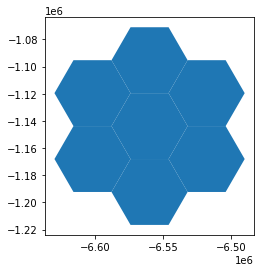

In [5]:
neighbors.loc[:, 'geometry'].plot()

In [ ]:
#      0
#    _____
# 5 /     \ 1
#  /       \
#  \       /
# 4 \_____/ 2
#      3

In [27]:
def computeDirection(polygon, neighbor):
    vector = (neighbor.centroid.x - polygon.centroid.x, neighbor.centroid.y - polygon.centroid.y)
    if abs(vector[0]) < 1000: # small epsilon
        return 0 if vector[1] < 0 else 3
    if vector[0] > 0:
        return 2 if vector[1] > 0 else 1
    return 4 if vector[1] > 0 else 5

In [28]:
def computeNeighbors(row):
    neighbors=[-1]*6
    for neighbor_id, neighbor_data in shapes[~shapes.geometry.disjoint(shapes.iloc[row.name]['geometry'])].iterrows():
        if row.name != neighbor_id:
            neighbors[computeDirection(row["geometry"], neighbor_data["geometry"])] = neighbor_id
    return neighbors

dask_shapes = dgpd.from_geopandas(shapes, npartitions=8)
to_compute = dask_shapes.apply(computeNeighbors, axis=1, result_type='expand')

In [25]:
to_compute

,0,1,2,3,4,5
npartitions=8,,,,,,
0,int64,int64,int64,int64,int64,int64
8206,...,...,...,...,...,...
...,...,...,...,...,...,...
57436,...,...,...,...,...,...
65640,...,...,...,...,...,...


In [29]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default

In [31]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:60449/status,
Dashboard: http://127.0.0.1:60449/status,Workers: 4
Total threads: 8,Total memory: 7.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60451,Workers: 4
Dashboard: http://127.0.0.1:60449/status,Total threads: 8
Started: Just now,Total memory: 7.90 GiB
Comm: tcp://127.0.0.1:60488,Total threads: 2
Dashboard: http://127.0.0.1:60489/status,Memory: 1.97 GiB
Nanny: tcp://127.0.0.1:60454,


In [32]:
result = to_compute.compute()

In [36]:
result.to_csv("world.csv")

In [33]:
import csv

graph = {}
with open('world.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for rows in reader:
        if len(rows[0]):
            data={}
            for i in range(6):
                k=int(rows[i+1])
                if k>0:
                    data[i]=k
            graph[int(rows[0])]=data

In [34]:
border_ids = [k for k in graph if len(graph[k])<6]
border = shapes.filter(items=border_ids, axis=0)

<AxesSubplot:>

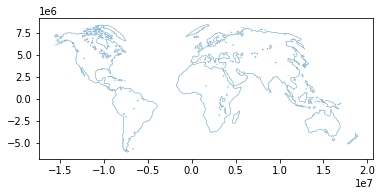

In [35]:
border.loc[:, 'geometry'].plot()

In [40]:
def computeBarycenter(row):
    polygon = row['geometry']
    return (polygon.centroid.x, polygon.centroid.y)

dask_shapes2 = dgpd.from_geopandas(shapes, npartitions=8)
to_compute2 = dask_shapes2.apply(computeBarycenter, axis=1, result_type='expand')
result2 = to_compute2.compute()
result2.to_csv("world_coord.csv")